# Forecasting

import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

importing data into pandas dataframe

In [2]:
# importing data into pandas dataframe
df = pd.read_csv('TSLA.csv', index_col=0, parse_dates=True, squeeze=True)
df.head(n=10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500
2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000
2010-07-09,3.516,3.580,3.310,3.480,3.480,20253000
2010-07-12,3.590,3.614,3.400,3.410,3.410,11012500


plotting closing price

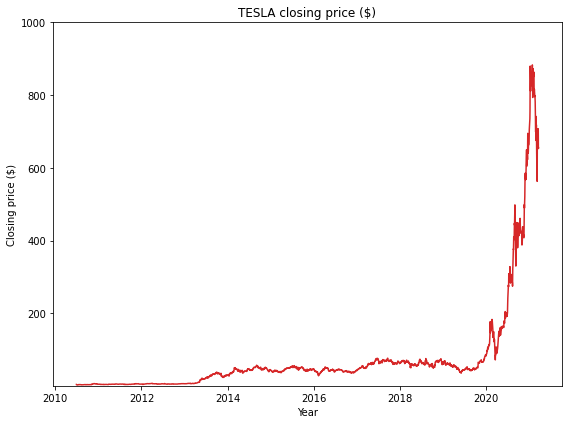

In [3]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8,6))
ax1.plot(df.iloc[:,4:5], 'tab:red')
ax1.set_title('TESLA closing price ($)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Closing price ($)')
ax1.set_ylim(1,1000)
fig.tight_layout()

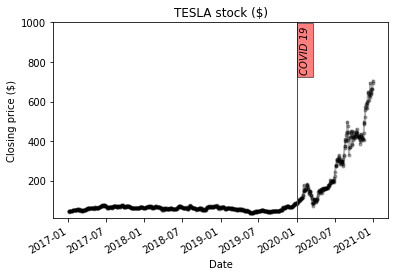

In [4]:
ax = df.loc['2017':'2020', 'Close'].plot(marker='.', alpha=0.3, linestyle='-', color='black' , linewidth=2)
ax.set_title('TESLA stock ($)')
ax.axvline(x='01-01-2020', color='red', linewidth=1)
ax.text('15-01-2020', 750, r'COVID 19', style='italic' , rotation=90 ,
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 3})
ax.set_ylim(10,1000)      
ax.set_ylabel('Closing price ($)');

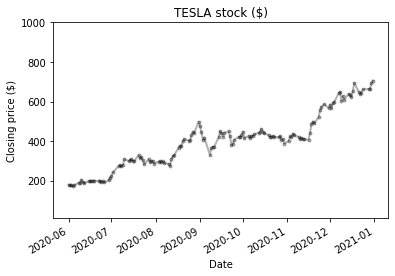

In [6]:
ax = df.loc['06-2020':'12-2020', 'Close'].plot(marker='.', alpha=0.3, linestyle='-', color='black' , linewidth=2)
ax.set_title('TESLA stock ($)')
ax.set_ylim(10,1000)      
ax.set_ylabel('Closing price ($)');

data preperation
Instead of Predicting the price itself calculate returns

In [5]:
# calculate returns by first shifting the data
df['PrevClose'] = df['Close'].shift(1)
df['Return'] = (df['Close'] - df['PrevClose']) / df['PrevClose']
df.head()

,Open,High,Low,Close,Adj Close,Volume,PrevClose,Return
Date,,,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,NaN,NaN
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,4.778,-0.002512
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,4.766,-0.078473
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,4.392,-0.125683
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,3.840,-0.160937


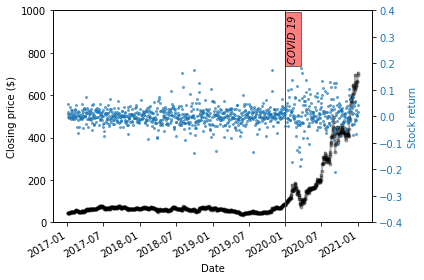

In [8]:
fig, ax2 = plt.subplots()

color = 'black'
ax2 = df.loc['01-2017':'12-2020', 'Close'].plot(marker='.', alpha=0.3, linestyle='-', color=color , linewidth=2, label='test')
ax2.set_ylabel('Closing price ($)', color=color)
ax2.tick_params(axis='y')
ax2.set_ylim(0,1000) 

ax2.axvline(x='01-01-2020', color='red', linewidth=1)
ax2.text('15-01-2020', 760, r'COVID 19', style='italic' , rotation=90 ,
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 3})

ax = ax2.twinx()
color = 'tab:blue'
ax = df.loc['01-2017':'12-2020', 'Return'].plot(marker='o', alpha=0.6, linestyle='-', color=color , linewidth=0, markersize=2)
ax.set_xlabel('Date')
ax.set_ylabel('Stock return', color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylim(-0.40,0.40)

fig.tight_layout();

plot distribution of stock price and stock return

<AxesSubplot:>

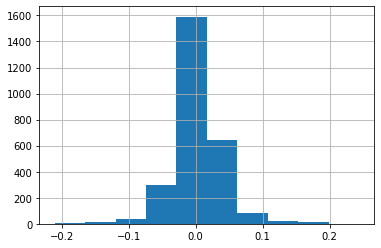

In [6]:
df['Return'].hist()

<AxesSubplot:>

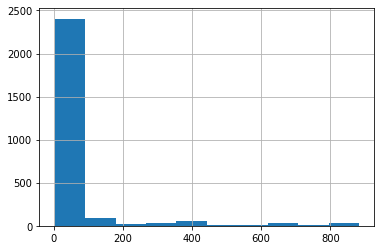

In [7]:
df['Close'].hist()

test to check stationarity

In [8]:
from statsmodels.tsa.stattools import adfuller as adf
print(adf(df['Return'].dropna()))
print(adf(df['Close'].dropna()))

(-51.71083727856841, 0.0, 0, 2698, {'1%': -3.432776068405479, '5%': -2.862611858714308, '10%': -2.5673405860421004}, -10252.201057090511)
(2.309583188484802, 0.9989611900236602, 28, 2671, {'1%': -3.4328006161256743, '5%': -2.862622699657979, '10%': -2.567346357793352}, 17604.625263211667)


model creation

In [9]:
series = df['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [10]:
T = 10 # number of days
D = 1  # default size
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2690, 10, 1) Y.shape (2690,)


In [11]:
# implementing keras functional approach to build model
# input shape of (10,1) 
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
lstm_model = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=100,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/100


In [ ]:
# Plot loss per iteration
plt.plot(lstm_model.history['loss'], label='loss')
plt.plot(lstm_model.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[-N//2:,0]

# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
# creating one-step prediction dataframe
data_onestep = {'Predicted': pd.Series(predictions), 'Target': pd.Series(pd.Series(Y[-N//2:]))}
df_one_step = pd.DataFrame(data_onestep)
df_one_step.head()

# creating multi-step prediction dataframe
data_multi_step = {'Predicted': pd.Series(validation_predictions), 'Target': pd.Series(pd.Series(validation_target))}
df_multi_step = pd.DataFrame(data_multi_step)
df_multi_step.head()

In [ ]:
# One-step forecast using true targets
fig, ax = plt.subplots()

color = 'tab:orange'
ax = df_one_step.loc[0:100, 'Predicted'].plot(marker='.', alpha=0.6, linestyle='-', color=color , linewidth=2, label='Predicted')
color = 'black'
ax = df_one_step.loc[0:100, 'Target'].plot(marker='o', alpha=0.6, linestyle='-', color=color , linewidth=2, markersize=2)
ax.tick_params(axis='y')
ax.set_ylim(1,3) 
ax.set_xlabel('Days')
ax.set_ylabel('standardized closing price', color='black')
ax.legend(loc="lower right");

In [ ]:
# Multi-step forecast using true targets
fig, ax = plt.subplots()

color = 'tab:orange'
ax = data_multi_step.loc[0:100, 'Predicted'].plot(marker='.', alpha=0.6, linestyle='-', color=color , linewidth=2, label='Predicted')
color = 'black'
ax = data_multi_step.loc[0:100, 'Target'].plot(marker='o', alpha=0.6, linestyle='-', color=color , linewidth=2, markersize=2)
ax.tick_params(axis='y')
ax.set_ylim(1,3) 
ax.set_xlabel('Days')
ax.set_ylabel('standardized closing price', color='black')
ax.legend(loc="lower right");

In [ ]:
# before and after covid
fig, ax2 = plt.subplots()

color = 'tab:orange'
ax2 = df_one_step.loc[950:1150, 'Predicted'].plot(marker='.', alpha=0.6, linestyle='-', color=color , linewidth=2, label='Predicted', markersize=0)
color = 'black'
ax2 = df_one_step.loc[950:1150, 'Target'].plot(marker='o', alpha=0.6, linestyle='-', color=color , linewidth=2, markersize=0)
ax2.set_ylabel('standardized closing price', color='black')
ax2.tick_params(axis='y')
ax2.axvline(x=1025, color='red', linewidth=1)
ax2.text(1028, 8, r'COVID 19', style='italic' , rotation=90 ,
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 3})
ax2.set_xlabel('Days')
ax2.legend(loc="lower right");